In [1]:
import numpy as np
import re
import json
from urllib.parse import urlparse
import tldextract as tld
from Cymon_API import *
import whois
import datetime
import seolib as seo

In [8]:
def getDomain(url):
    t_url = tld.extract(url)
    dm = t_url.domain
    sdm = t_url.subdomain
    sfx = t_url.suffix
    domain = sdm+'.'+dm+'.'+sfx
    return domain

def is_ip(url):
    finder = re.compile(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}')
    check = finder.search(url)
    if check is not None:
        return 1
    return -1

def is_too_long(url):
    if(len(url)<54):
        return -1
    if(len(url)>=75):
        return 1
    else:
        return 0

def is_shortened(url):
    if('bit.ly' in url):
        return 1
    return -1

def has_at(url):
    if('@' in url):
        return 1
    return -1

def has_redirect(url):
    finder = re.compile(r'//')
    fs = finder.search(url)
    if fs is None:
        return -1
    else:
        location = fs.end()
        if(location >7):
            return 1
    return -1

def has_dash(url):
    extracted_url = tld.extract(url)
    if('-' in extracted_url.domain or '-' in extracted_url.subdomain):
        return 1
    return -1

def has_multi_subdomain(url):
    finder = re.compile(r'www\.')
    url = finder.sub('',url)
    t_url = tld.extract(url)
    dm = t_url.domain
    sdm = t_url.subdomain
    dot_count = dm.count('.') + sdm.count('.') + (not sdm == '')+1
    if(dot_count == 1):
        return -1
    if(dot_count>2):
        return 1
    else:
        return 0
    
def has_https(url):
    #Get https certificate
    if 'https' in url:
        return 1
    return -1
    
def records_exist(url):
    try:
        q = whois.query(getDomain(url))
        if q is not None:
            return -1
        else:
            return 1
    except:
        return 1

def domain_age(url):
    try:
        creation_date = whois.query(getDomain(url)).creation_date
        age = datetime.datetime.now()-domain.creation_date.days*1./365
        if(age <= 0.5):
            return 1
        else:
            return -1
    except:
        return 1
    
def check_domain(url):
    finder = re.compile(r'www\.')
    url = finder.sub('',url)
    t_url = tld.extract(url)
    dm = t_url.domain
    sdm = t_url.subdomain
    sfx = t_url.suffix
    data = lookup_domain(sdm+'.'+dm+'.'+sfx)
    if data == None:
        return 1
    elif len(data)>1:
        return -1
    else:
        return 1

def webTraffic(url):
    alexa_rank = seo.get_alexa(url)
    if alexa_rank is None:
        return 1
    elif alexa_rank < 100000:
        return -1
    else:
        return 0
    
'''
def registration_length(url):
    #Check domain registration expires in >= 1 year
    return False

def check_favicon(url):
    #Check if favicon is loaded from domain other than url
    return False
'''
nf = 8
def getFeatures(url):
    features = [0]*11
    features[0] = is_ip(url)
    features[1] = is_too_long(url)
    features[2] = is_shortened(url)
    features[3] = has_at(url)
    features[4] = has_redirect(url)
    features[5] = has_dash(url)
    features[6] = has_multi_subdomain(url)
    features[7] = has_https(url)
    features[8] = records_exist(url)
    features[9] = domain_age(url)
    features[10] = check_domain(url)
    #features[8] = registration_length(url)
    #features[9] = check_favicon(url)
    return features

None


In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
import warnings; warnings.simplefilter('ignore')
import itertools
import graphviz 

data = []
with open('phishing_data.txt','r') as phishing_file:
    for counter,line in enumerate(phishing_file):
        data.append([float(i) for i in line.rstrip('\n').split(',')])
        
data = np.array(data)
print(len(data),len(data[0]))

train_size = 10000
test_size = 500
a = np.arange(0,nf).astype(int)
b = np.array([23,24,29]).astype(int)
idx = np.concatenate((a,b))
train = [data[0:train_size,idx],data[0:train_size,30]]
test = [data[train_size+1:train_size+test_size+1,idx],data[train_size+1:train_size+test_size+1,30]]
#print(1-np.sum((test[1]/2)+0.5)/len(test[1]))
#print(1-np.sum(data[:,30])/len(data))
print(np.sum(train[1]==-1)/len(train[1]))
print(np.sum(train[1]==1)/len(train[1]))
print('Test good vs bad')
print(np.sum(test[1]==-1)/len(test[1]))
print(np.sum(test[1]==1)/len(test[1]))

11055 31
0.4437
0.5563
Test good vs bad
0.448
0.552


{'min_samples_split': 3, 'max_depth': 2}
Score:  0.922
Confusion:
 [[203  21]
 [ 18 258]]
(0.9247311827956989, 0.9347826086956522, 0.9297297297297297, None)
precision      recall        fscore


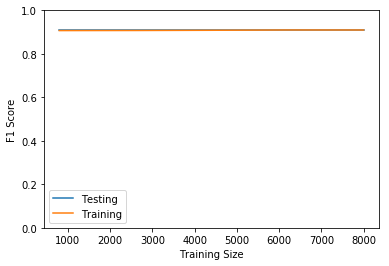

In [10]:
clf = tree.DecisionTreeClassifier()
parameters = {'max_depth':[1,2,3,4,5,6,7,8],'min_samples_split':[3,4,5,10,20,30,40,50]}
clf = GridSearchCV(clf, parameters, cv=5,scoring = 'f1')
clf = clf.fit(train[0],train[1])
score = clf.best_estimator_.score(test[0],test[1])
print(clf.best_params_)
print('Score: ',score)
cm = confusion_matrix(test[1],clf.predict(test[0]))
print('Confusion:\n',cm)
print(precision_recall_fscore_support(test[1],clf.best_estimator_.predict(test[0]), average='binary'))
print('precision      recall        fscore')
decision_tree_scores = clf.cv_results_
dt = clf

a = learning_curve(dt.best_estimator_,train[0],train[1],scoring = 'f1',cv = 5,train_sizes = np.linspace(0.1,1,5))
plt.plot(a[0],np.mean(a[2],axis = 1))
plt.plot(a[0],np.mean(a[1],axis = 1))
plt.ylim([0,1])
plt.ylabel('F1 Score')
plt.xlabel('Training Size')
plt.legend(['Testing','Training'])
plt.show()

{'n_estimators': 500, 'max_depth': 1}
Score:  0.922
Confusion:
 [[203  21]
 [ 18 258]]
(0.9247311827956989, 0.9347826086956522, 0.9297297297297297, None)
precision      recall        fscore


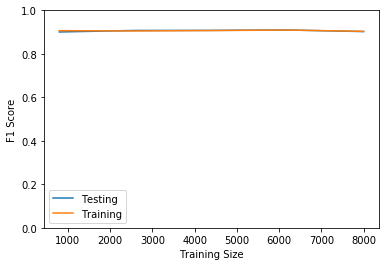

In [167]:
clf = RandomForestClassifier()
parameters = {'max_depth':[1,2,3,4],'n_estimators':[5,20,100,500]}
clf = GridSearchCV(clf, parameters, cv=5,scoring = 'f1')
clf = clf.fit(train[0],train[1])
score = clf.best_estimator_.score(test[0],test[1])
print(clf.best_params_)
print('Score: ',score)
cm = confusion_matrix(test[1],clf.predict(test[0]))
print('Confusion:\n',cm)
print(precision_recall_fscore_support(test[1],clf.best_estimator_.predict(test[0]), average='binary'))
print('precision      recall        fscore')
decision_tree_scores = clf.cv_results_
dt = clf

a = learning_curve(clf.best_estimator_,train[0],train[1],scoring = 'f1',cv = 5,train_sizes = np.linspace(0.1,1,5))
plt.plot(a[0],np.mean(a[2],axis = 1))
plt.plot(a[0],np.mean(a[1],axis = 1))
plt.ylim([0,1])
plt.ylabel('F1 Score')
plt.xlabel('Training Size')
plt.legend(['Testing','Training'])
plt.show()

In [11]:
bad_data = []
label = []

with open('bad_domains.txt','r') as phishing_file:
    for counter,line in enumerate(phishing_file):
        if(counter < 100):
            bad_data.append(line.rstrip('\n'))
            label.append(-1)

with open('top500.csv','r') as phishing_file:
    for counter,line in enumerate(phishing_file):
        bad_data.append(line.rstrip('\n').split(',')[1])
        label.append(1)
        
td = []
for c,v in enumerate(bad_data):
    f = getFeatures(v)
    td.append(f)
    print(c,end='\r')
    
score = clf.best_estimator_.score(td,label)
print(score)

cm = confusion_matrix(label,clf.predict(td))
print('Confusion:\n',cm)



0.15833333333333333
Confusion:
 [[ 89  11]
 [494   6]]


In [13]:
print(clf.best_estimator_.predict(np.array(getFeatures('https://www.sbnation.com')).reshape(1,-1)))



[1.]


In [175]:
#print(train[0][0:40])
print(train[1][0:40] == 1)

[False False False False  True  True False False  True False  True False
 False False  True False False False  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True False False
 False False  True  True]


In [36]:
url = 'https://www.malware.com//123.123.123.123'
print(getFeatures(url))

[True, False, False, False, True, False, True, False, False, False, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [53]:
a = [1,2,3,4,5,6,7,8]
print(a[0:8])

[1, 2, 3, 4, 5, 6, 7, 8]


In [24]:
url = 'bit.ly/19D@XSk4'
print('@' in url)
print(lookup_domain('hiepkute1970.zapto.org'))

True
{'name': 'hiepkute1970.zapto.org', 'updated': '2015-07-07T14:14:11Z', 'created': '2015-07-07T14:14:11Z', 'sources': ['malwr.com'], 'ips': ['https://cymon.io/api/nexus/v1/ip/42.115.158.45'], 'urls': []}


In [25]:
a = urlparse('https://docs.python.org/2/library/urlparse.html')
print(tld.extract('http://www.paypalsecure-2016.sucurecode524154241.arita.ac.tz'))

ExtractResult(subdomain='www.paypalsecure-2016.sucurecode524154241', domain='arita', suffix='ac.tz')


In [47]:
print(has_multi_subdomain('paypalsecure-2016.sucurecode524154241.arita.ac.tz'))
print(tld.extract('paypalsecure-2016.sucurecode524154241.arita.ac.tz'))

True
ExtractResult(subdomain='paypalsecure-2016.sucurecode524154241', domain='arita', suffix='ac.tz')


In [221]:
print(check_domain('google.com'))

1


In [233]:
a = np.array([1,2,3,4,5,6])
print(a[np.arange(0,2)])

[1 2]


In [301]:
url = 'dawnsworld.mysticalgateway.com'
t_url = tld.extract(url)
domain = whois.query('docs.python.org')
print(domain.creation_date)
print((datetime.datetime.now()-domain.creation_date).days*1./365)

ValueError: Unknown date format: 'registrar: gandi sas'

In [298]:
print(getDomain('https://docs.python.org/2/library/urlparse.html'))

docs.python.org
